# Predicting Resolver Response Code Based on Query Headers and Zone Information

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import sklearn.preprocessing, sklearn.model_selection, sklearn.tree
import graphviz 
import matplotlib.pyplot as plt

In [2]:
ALGO_NAME = {
    5: 'rsasha1', 
    7: 'rsasha1nsec3sha1', 
    8: 'rsasha256', 
    10: 'rsasha512',
    13: 'ecdsap256sha256', 
    14: 'ecdsap384sha384', 
    15: 'ed25519', 
    16: 'ed448',
}
ALGO_NUM = {name: num for num, name in ALGO_NAME.items()}
# defining priority (from low to high)
priority = [ALGO_NAME[key] for key in sorted(ALGO_NAME.keys())]

## Prepare Data

In [3]:
data = {
    name: pd.read_pickle(f'ml_data_{name}.pickle')
    for name in ALGO_NAME.values()
}

In [4]:
features = list(filter(lambda c: c.startswith('feature_dns'), next(iter(data.values())).keys()))
labels = list(filter(lambda c: c.startswith('label_'), next(iter(data.values())).keys()))
label = 'label_rcode0andad1'

### Display all Features that have *any* Variability

In [5]:
features = list(filter(lambda f: f != 'feature_ip_src', features))

In [6]:
for algo, d in data.items():
    print(f'++++{algo}++++', len(d), 'total queries')
    for c in features + labels:
        u = np.unique(d[c], return_counts=True)
        if len(u[0]) > 1:
            print(f"{c}: {len(u[0])} unique values")

++++rsasha1++++ 166 total queries
feature_dns_cd: 2 unique values
feature_dns_edns_requestors_udp_payload_size: 8 unique values
feature_dns_0x20: 2 unique values
feature_dns_edns_cookie: 2 unique values
feature_dns_edns_subnet: 2 unique values
label_rcode: 2 unique values
label_resolver: 14 unique values
label_rcode0andad1: 2 unique values
++++rsasha1nsec3sha1++++ 168 total queries
feature_dns_cd: 2 unique values
feature_dns_edns_requestors_udp_payload_size: 8 unique values
feature_dns_0x20: 2 unique values
feature_dns_edns_cookie: 2 unique values
feature_dns_edns_subnet: 2 unique values
label_rcode: 2 unique values
label_resolver: 14 unique values
label_rcode0andad1: 2 unique values
++++rsasha256++++ 168 total queries
feature_dns_cd: 2 unique values
feature_dns_edns_requestors_udp_payload_size: 8 unique values
feature_dns_0x20: 2 unique values
feature_dns_edns_cookie: 2 unique values
feature_dns_edns_subnet: 2 unique values
label_rcode: 2 unique values
label_resolver: 14 unique values

In [33]:
data['ed448'].keys()

Index(['id', 'qname', 'tag', 'started', 'server_packets', 'finished',
       'zone_algorithm', 'zone_keysize', 'zone_nsec', 'zone_status',
       'resolver', 'qlabel', 'num_client_packets', 'client_query',
       'client_response', 'client_response_rcode', 'client_response_ad',
       'num_server_packets', 'server_query', 'validated_response', 'rc0&ad1',
       'rc0', 'label_rcode', 'label_resolver', 'label_rcode0andad1',
       'feature_ip_ttl', 'feature_ip_src', 'feature_ip_proto', 'feature_ip_df',
       'feature_ip_ihl', 'feature_ip_id_is_zero', 'feature_dns_qr',
       'feature_dns_opcode', 'feature_dns_aa', 'feature_dns_tc',
       'feature_dns_rd', 'feature_dns_ra', 'feature_dns_z', 'feature_dns_cd',
       'feature_dns_rcode', 'feature_dns_qdcount', 'feature_dns_ancount',
       'feature_dns_nscount', 'feature_dns_arcount',
       'feature_dns_edns_requestors_udp_payload_size', 'feature_dns_0x20',
       'feature_dns_edns_cookie', 'feature_dns_edns_subnet',
       'resolver res

In [42]:
tdata = data['ed448'][['feature_dns_cd', 'feature_dns_edns_requestors_udp_payload_size', 'feature_dns_0x20', 'feature_dns_edns_cookie', 'feature_dns_edns_subnet', 'client_response_rcode', 'client_response_ad', 'label_rcode0andad1']]
tdata.columns = ['CD bit set', 'Advertised UDP Payload Size', 'Uses 0x20 Encoding', 'Sets EDNS Cookie', 'Advertises Subnet', 'Response Code', 'AD bit set', 'Label']
print(tdata[:5].to_latex(
    index=False,
))
tdata

\begin{tabular}{rrlllrrl}
\toprule
 CD bit set &  Advertised UDP Payload Size &  Uses 0x20 Encoding &  Sets EDNS Cookie &  Advertises Subnet &  Response Code &  AD bit set &  Label \\
\midrule
          1 &                         4000 &                True &             False &              False &              0 &           0 &  False \\
          1 &                         4000 &                True &             False &              False &              0 &           0 &  False \\
          1 &                         4000 &               False &             False &              False &              0 &           0 &  False \\
          1 &                         4000 &               False &             False &              False &              0 &           0 &  False \\
          0 &                         1232 &               False &             False &              False &              0 &           1 &   True \\
\bottomrule
\end{tabular}



,CD bit set,Advertised UDP Payload Size,Uses 0x20 Encoding,Sets EDNS Cookie,Advertises Subnet,Response Code,AD bit set,Label
10,1,4000,True,False,False,0,0,False
11,1,4000,True,False,False,0,0,False
55,1,4000,False,False,False,0,0,False
56,1,4000,False,False,False,0,0,False
100,0,1232,False,False,False,0,1,True
101,0,1232,False,False,False,0,1,True
152,1,1232,True,False,False,0,0,False
153,1,1232,True,False,False,0,0,False
204,1,4096,False,False,False,0,0,False
205,1,4096,False,False,False,0,0,False


In [31]:
data['ed448'][['feature_dns_cd', 'feature_dns_edns_requestors_udp_payload_size', 'feature_dns_0x20', 'feature_dns_edns_cookie', 'feature_dns_edns_subnet', 'label_rcode0andad1']]

,feature_dns_cd,feature_dns_edns_requestors_udp_payload_size,feature_dns_0x20,feature_dns_edns_cookie,feature_dns_edns_subnet,label_rcode0andad1
10,1,4000,True,False,False,False
11,1,4000,True,False,False,False
55,1,4000,False,False,False,False
56,1,4000,False,False,False,False
100,0,1232,False,False,False,True
101,0,1232,False,False,False,True
152,1,1232,True,False,False,False
153,1,1232,True,False,False,False
204,1,4096,False,False,False,False
205,1,4096,False,False,False,False


### Encode String-Based Features

In [7]:
for d in data.values():
    le_feature_ip_src = sk.preprocessing.LabelEncoder()
    le_feature_ip_src.fit(d['feature_ip_src'])
    d['feature_ip_src'] = le_feature_ip_src.transform(d['feature_ip_src'])

## Train and Evaluate Decision Tree

In [8]:
tree = {}

for algo, d in data.items():
    X = d[features]
    Y = d[label]
    X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, train_size=0.7, random_state=1)

    tree[algo] = sk.tree.DecisionTreeClassifier()
    tree[algo] = tree[algo].fit(X_train, Y_train)

### Evaluate Prediction Error

In [9]:
metrics = []

for seed in range(10):
    for algo, t in tree.items():
        d = data[algo]
        X = d[features]
        Y = d[label]
        X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, train_size=0.5, random_state=4)
        cm = sklearn.metrics.confusion_matrix(t.predict(X_test), Y_test) / len(Y_test)
        metrics.append({
            'algo': algo,
            'true negative': cm[0,0],
            'true positive': cm[1,1],
            'false negative': cm[0,1],
            'false positive': cm[1,0],
            'seed': seed,
        })
        
metrics = pd.DataFrame(metrics)
metrics = metrics.groupby(['algo']).mean().sort_values('algo', key=lambda r: list(map(lambda e: priority.index(e), r)))
del metrics['seed']
print(metrics.to_latex(
    float_format=lambda f: f"{f:.0%}",
))
metrics

\begin{tabular}{lrrrr}
\toprule
{} &  true negative &  true positive &  false negative &  false positive \\
algo             &                &                &                 &                 \\
\midrule
rsasha1          &            28\% &            28\% &             14\% &             30\% \\
rsasha1nsec3sha1 &             5\% &            90\% &              0\% &              5\% \\
rsasha256        &             5\% &            89\% &              0\% &              6\% \\
rsasha512        &             6\% &            88\% &              0\% &              6\% \\
ecdsap256sha256  &            19\% &            62\% &              5\% &             14\% \\
ecdsap384sha384  &            19\% &            67\% &              5\% &             10\% \\
ed25519          &            71\% &            14\% &             14\% &              0\% \\
ed448            &            81\% &             5\% &             14\% &              0\% \\
\bottomrule
\end{tabular}



,true negative,true positive,false negative,false positive
algo,,,,
rsasha1,0.277108,0.277108,0.144578,0.301205
rsasha1nsec3sha1,0.047619,0.904762,0.000000,0.047619
rsasha256,0.047619,0.892857,0.000000,0.059524
rsasha512,0.059524,0.880952,0.000000,0.059524
ecdsap256sha256,0.190476,0.619048,0.047619,0.142857
ecdsap384sha384,0.190476,0.666667,0.047619,0.095238
ed25519,0.714286,0.142857,0.142857,0.000000
ed448,0.809524,0.047619,0.142857,0.000000


In [10]:
correct = {}

for seed in range(10):
    for algo, t in tree.items():
        d = data[algo]
        X = d[features]
        Y = d[label]
        X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, train_size=0.5, random_state=4)

        #sklearn.metrics.plot_confusion_matrix(t, X_test, Y_test, display_labels=['bad\n(rcode != 0 OR\nad != 1)', 'good\n(rcode = 0 AND\nad = 1)'])
        cm = sklearn.metrics.confusion_matrix(t.predict(X_test), Y_test)
        c = np.sum(np.diagonal(cm))/len(Y_test)
        title = f"{algo} (correct {c:.0%}, false 'bad': {cm[0,1]}, false 'good': {cm[1,0]})"
        correct.setdefault(algo, [c]).append(c)
        #plt.title(title)
        #print(title)
        
{
    algo: np.round(np.mean(cs), 3) for algo, cs in correct.items()
}

{'rsasha1': 0.554,
 'rsasha1nsec3sha1': 0.952,
 'rsasha256': 0.94,
 'rsasha512': 0.94,
 'ecdsap256sha256': 0.81,
 'ecdsap384sha384': 0.857,
 'ed25519': 0.857,
 'ed448': 0.857}

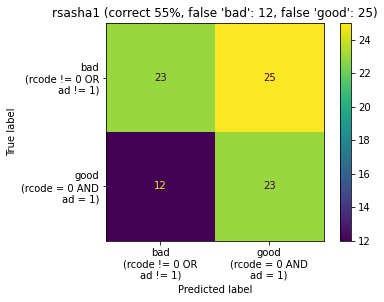

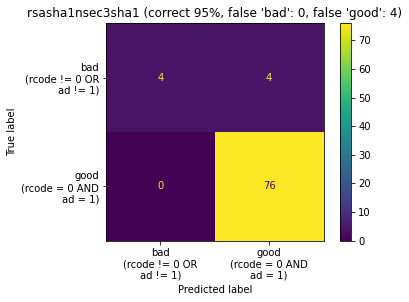

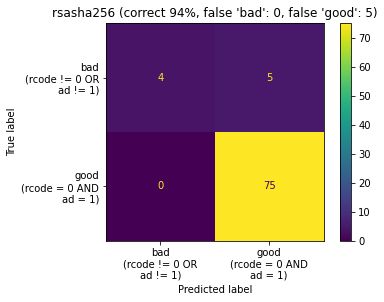

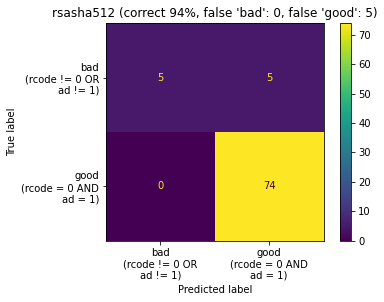

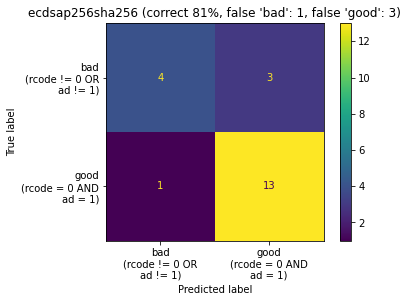

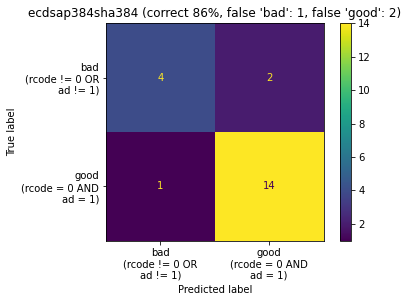

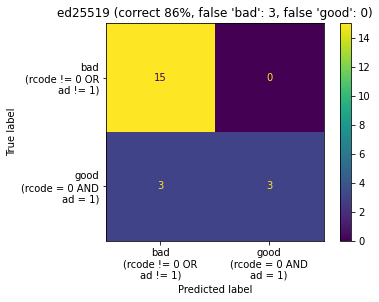

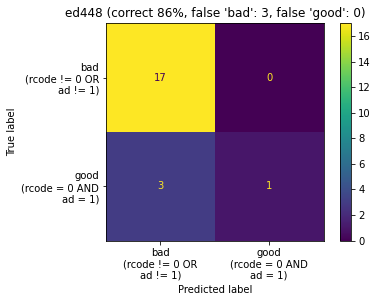

In [11]:
for algo, t in tree.items():
    d = data[algo]
    X = d[features]
    Y = d[label]
    X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, train_size=0.5, random_state=4)

    sklearn.metrics.plot_confusion_matrix(t, X_test, Y_test, display_labels=['bad\n(rcode != 0 OR\nad != 1)', 'good\n(rcode = 0 AND\nad = 1)'])
    cm = sklearn.metrics.confusion_matrix(t.predict(X_test), Y_test)
    c = np.sum(np.diagonal(cm))/len(Y_test)
    title = f"{algo} (correct {c:.0%}, false 'bad': {cm[0,1]}, false 'good': {cm[1,0]})"
    plt.title(title)


## Show Decision Tree

In [12]:
graphs = {}

for algo, t in tree.items():
    dot_data = sk.tree.export_graphviz(
        t, out_file=None, 
        feature_names=features,  
        class_names=['OK', 'Failure'],  
        filled=True, rounded=True,  
        special_characters=True,
        impurity=True,
    )  
    graphs[algo] = graphviz.Source(dot_data)  

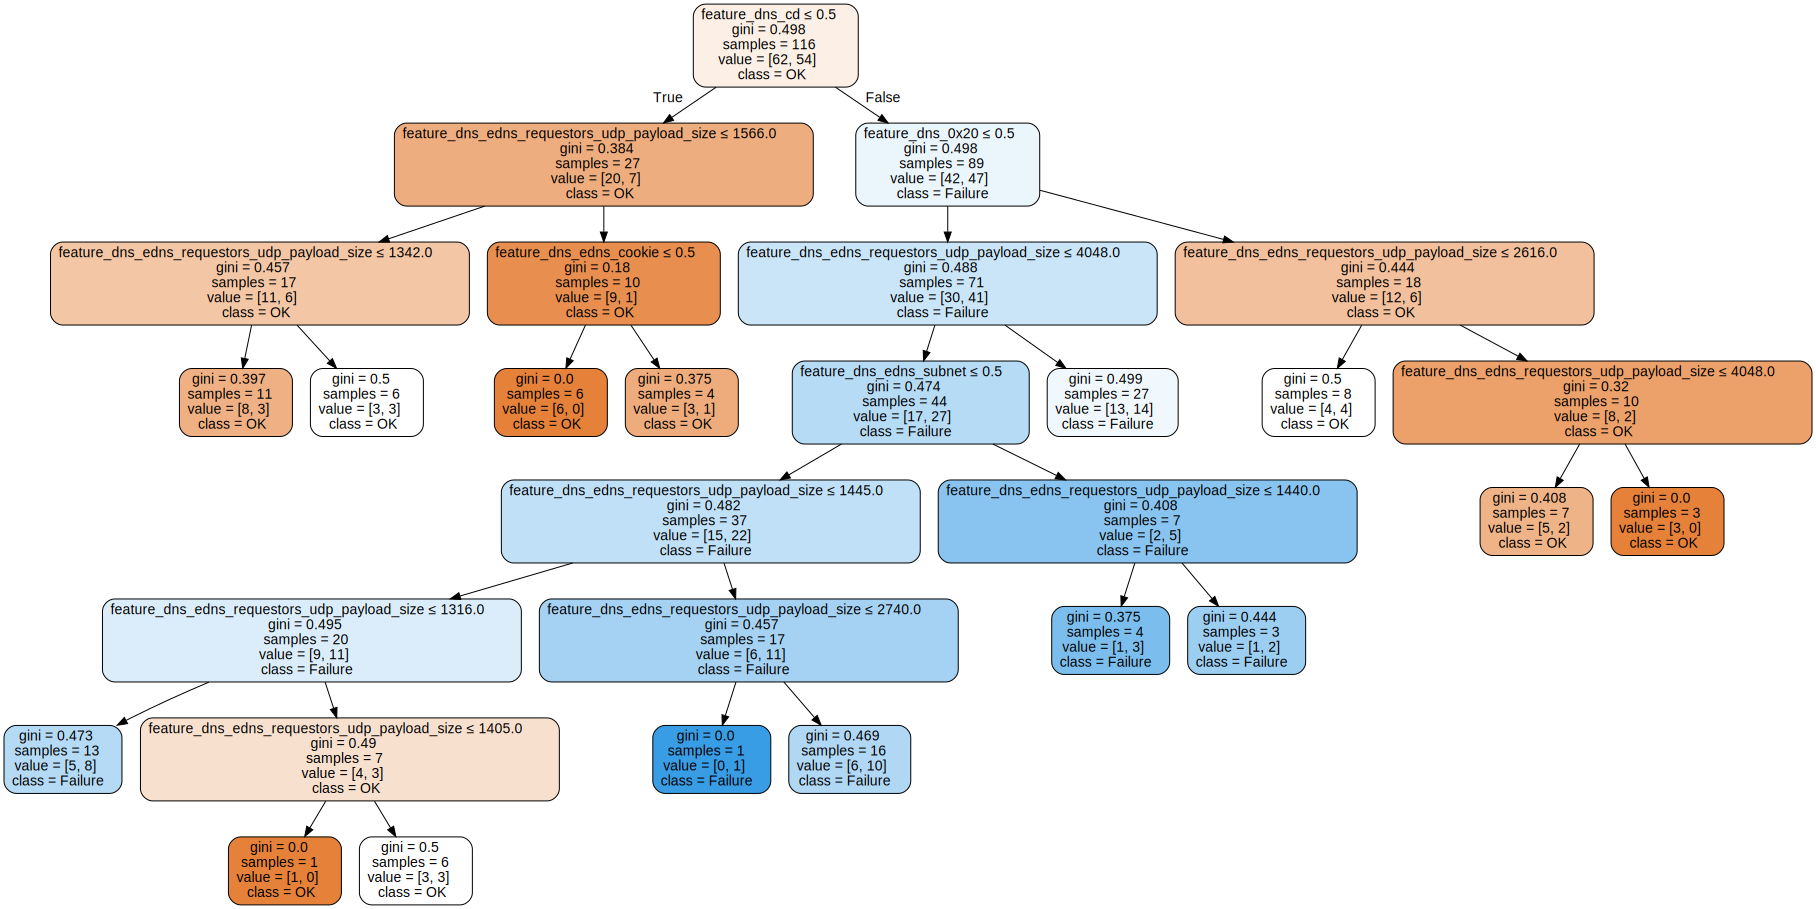

In [13]:
graphs['rsasha1']

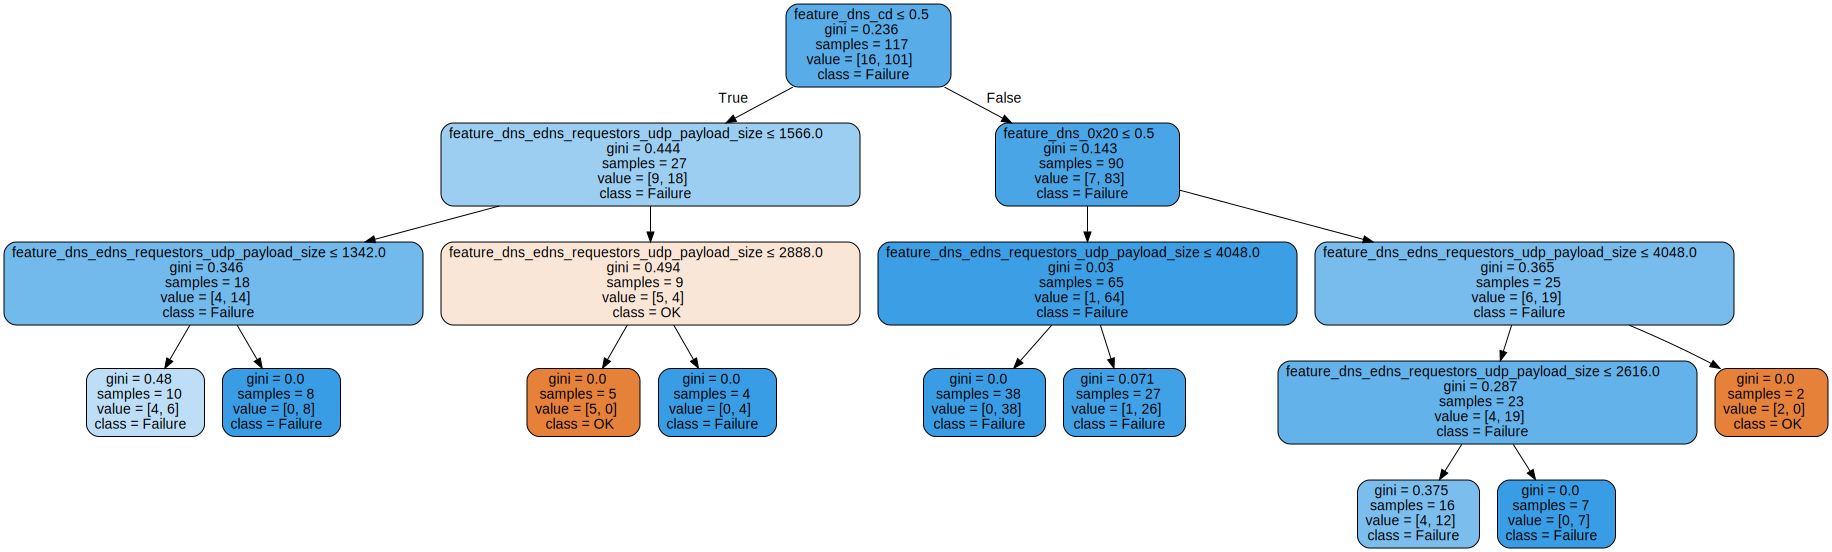

In [14]:
graphs['rsasha1nsec3sha1']

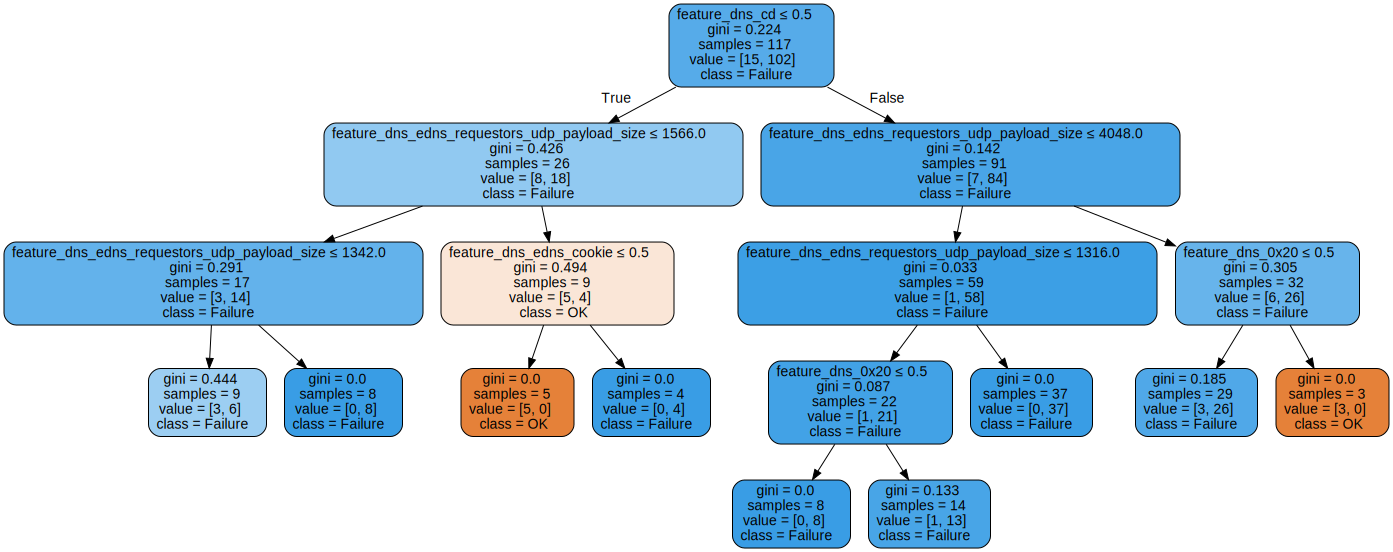

In [15]:
graphs['rsasha256']

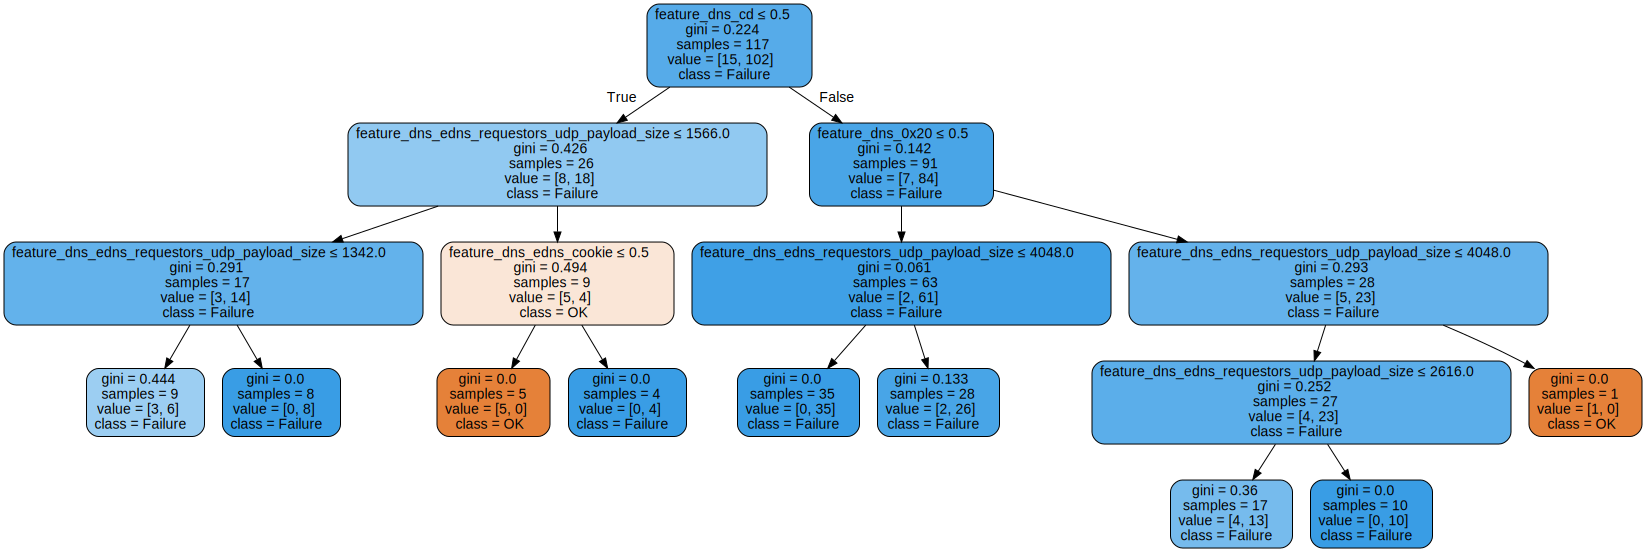

In [16]:
graphs['rsasha512']

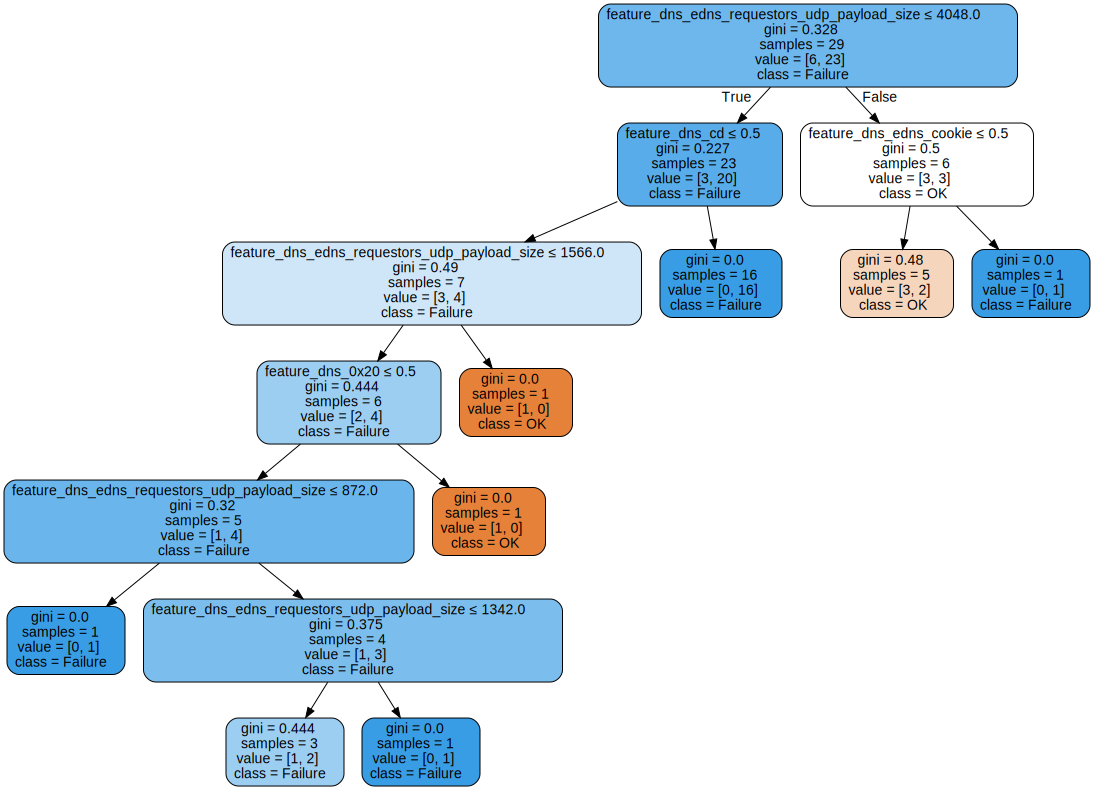

In [17]:
graphs['ecdsap256sha256']

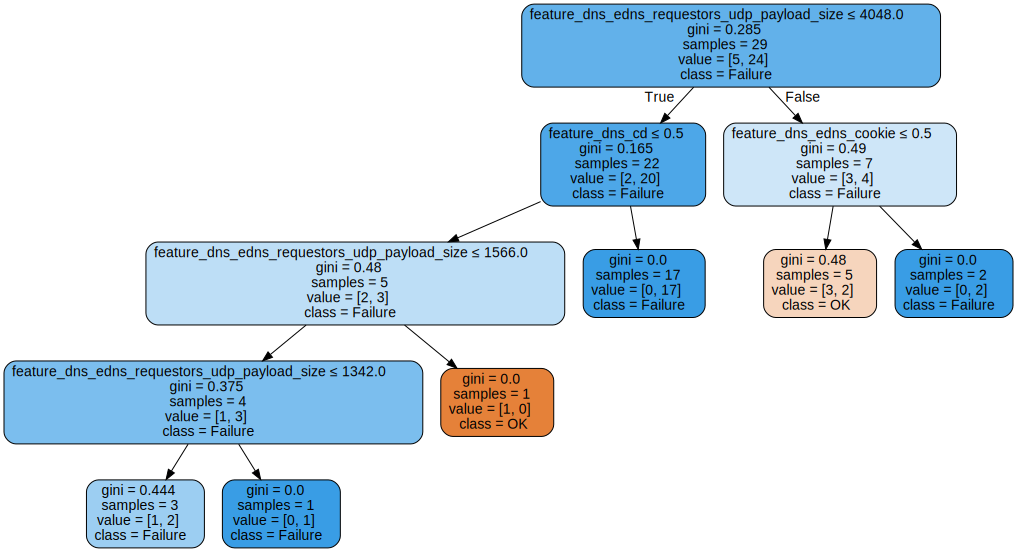

In [18]:
graphs['ecdsap384sha384']

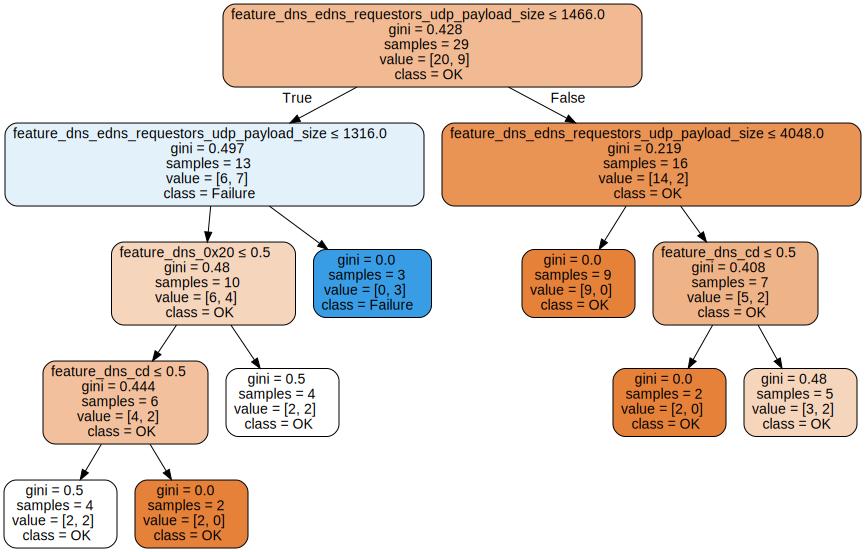

In [19]:
graphs['ed25519']

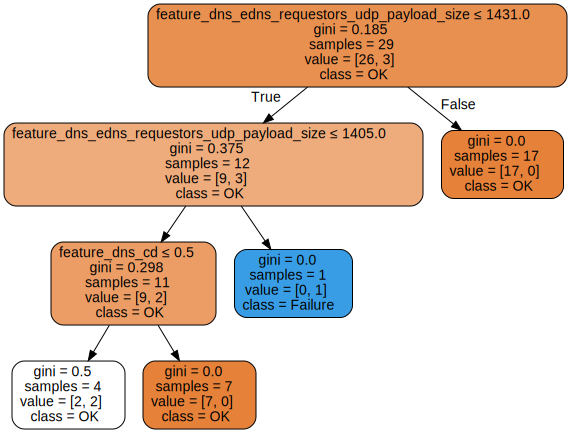

In [20]:
graphs['ed448']

# Predicting Cipher

In [21]:
# putting all data together
fdata = pd.concat([d for d in data.values()])

In [22]:
# predicting for each algorithm
X = fdata[features]
Y = fdata[label]

for algo, t in tree.items():
    fdata[f'pred_{algo}'] = t.predict(X)

In [23]:
# computing choice for each row
fdata['selected'] = priority[-1]
for algo in priority:
    fdata.loc[fdata[f'pred_{algo}'], 'selected'] = algo

In [24]:
fdata[['resolver', 'qname', 'selected'] + [f'pred_{algo}' for algo in priority]]

,resolver,qname,selected,pred_rsasha1,pred_rsasha1nsec3sha1,pred_rsasha256,pred_rsasha512,pred_ecdsap256sha256,pred_ecdsap384sha384,pred_ed25519,pred_ed448
12,20210624190851,b'lab-ws2019-20210624190851.rsasha1-1024-1-sig...,ecdsap384sha384,False,True,True,True,True,True,False,False
13,20210624190851,b'lab-ws2019-20210624190851.rsasha1-1024-3-sig...,ecdsap384sha384,False,True,True,True,True,True,False,False
14,20210624190851,b'lab-ws2019-20210624190851.rsasha1-1871-1-sig...,ecdsap384sha384,True,True,True,True,True,True,False,False
15,20210624190851,b'lab-ws2019-20210624190851.rsasha1-1871-3-sig...,ecdsap384sha384,False,True,True,True,True,True,False,False
16,20210624190851,b'lab-ws2019-20210624190851.rsasha1-2048-1-sig...,ecdsap384sha384,True,True,True,True,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...
851,oracle,b'opn-named-oracle-dyn-20210624190031.ed448-45...,ecdsap384sha384,True,True,True,True,True,True,False,False
898,opennic,b'opn-named-opennic-20210624190031.ed448-456-1...,ecdsap384sha384,False,True,True,True,True,True,False,False
899,opennic,b'opn-named-opennic-20210624190031.ed448-456-3...,ecdsap384sha384,False,True,True,True,True,True,False,False
998,freenom,b'opn-named-freenom-world-20210624190031.ed448...,ecdsap384sha384,True,True,True,True,True,True,False,False


In [25]:
resolver_best = pd.read_pickle('resolver_best.pickle')[('zone_algorithm', 'best_algo')].to_dict()
resolver_best

{'20210624190851': 'ecdsap384sha384',
 'Comodo': 'ed448',
 'cisco': 'ed448',
 'cloudflare': 'ed25519',
 'cznic': 'ed25519',
 'freenom': 'ecdsap384sha384',
 'google': 'ed25519',
 'neustar': 'rsasha512',
 'norton': 'rsasha512',
 'oracle': 'ecdsap384sha384',
 'quad9': 'ed448',
 'verisgn': 'rsasha512'}

In [26]:
fdata['best_algo'] = fdata.apply(lambda row: resolver_best.get(row['resolver'], priority[-1]), axis=1)

In [27]:
resolvers = set(resolver_best.keys()) | set(fdata['resolver'].unique())
resolvers_lab = {'bind9113',
 'powerdns460',
 'unbound167',
 'ws2012',
 'ws2012r2',
 'ws2016',
 'ws2019'}
resolvers_named_open = resolvers - resolvers_lab
resolver_order = list(sorted(resolvers_lab)) + list(sorted(resolvers_named_open))
resolver_order

['bind9113',
 'powerdns460',
 'unbound167',
 'ws2012',
 'ws2012r2',
 'ws2016',
 'ws2019',
 '20210624190851',
 'Comodo',
 'cisco',
 'cloudflare',
 'cznic',
 'freenom',
 'google',
 'neustar',
 'norton',
 'opennic',
 'oracle',
 'quad9',
 'verisgn',
 'yandex']

In [28]:
fdata['best supported'] = fdata.apply(lambda row: resolver_best.get(row['resolver'], None), axis=1)
fdata['pred_num'] = fdata.apply(lambda row: ALGO_NUM[row['selected']], axis=1)
fdata['best_algo_num'] = fdata.apply(lambda row: ALGO_NUM.get(row['best_algo'], None), axis=1)
fdata['correct'] = (fdata['selected'] == fdata['best_algo']).astype(np.float)
fdata['overestimated'] = (fdata['pred_num'] > fdata['best_algo_num']).astype(np.float)
fdata['underestimated'] = (fdata['pred_num'] < fdata['best_algo_num']).astype(np.float)
fdata['better than recommended'] = (fdata['pred_num'] > 13).astype(np.float)

In [29]:
fdata[['resolver', 'qname', 'selected', 'best supported', 'correct', 'overestimated', 'underestimated']]

,resolver,qname,selected,best supported,correct,overestimated,underestimated
12,20210624190851,b'lab-ws2019-20210624190851.rsasha1-1024-1-sig...,ecdsap384sha384,ecdsap384sha384,1.0,0.0,0.0
13,20210624190851,b'lab-ws2019-20210624190851.rsasha1-1024-3-sig...,ecdsap384sha384,ecdsap384sha384,1.0,0.0,0.0
14,20210624190851,b'lab-ws2019-20210624190851.rsasha1-1871-1-sig...,ecdsap384sha384,ecdsap384sha384,1.0,0.0,0.0
15,20210624190851,b'lab-ws2019-20210624190851.rsasha1-1871-3-sig...,ecdsap384sha384,ecdsap384sha384,1.0,0.0,0.0
16,20210624190851,b'lab-ws2019-20210624190851.rsasha1-2048-1-sig...,ecdsap384sha384,ecdsap384sha384,1.0,0.0,0.0
...,...,...,...,...,...,...,...
851,oracle,b'opn-named-oracle-dyn-20210624190031.ed448-45...,ecdsap384sha384,ecdsap384sha384,1.0,0.0,0.0
898,opennic,b'opn-named-opennic-20210624190031.ed448-456-1...,ecdsap384sha384,None,0.0,0.0,1.0
899,opennic,b'opn-named-opennic-20210624190031.ed448-456-3...,ecdsap384sha384,None,0.0,0.0,1.0
998,freenom,b'opn-named-freenom-world-20210624190031.ed448...,ecdsap384sha384,ecdsap384sha384,1.0,0.0,0.0


In [30]:
def list_values(c):
    c = set(c)
    if len(c) == 1:
        return next(iter(c))
    return c

def single_value(c):
    c = set(c)
    if len(c) == 0:
        return None
    if len(c) == 1:
        return next(iter(c))
    raise ValueError(set(c))

cipher_selection = fdata[~fdata['best_algo'].isna()].groupby(['resolver']).agg({
    'selected': [list_values],
    'best supported': [single_value],
    'correct': ['mean'],
    'underestimated': ['mean'],
    'overestimated': ['mean'],
    'better than recommended': ['mean'],
}).sort_values('resolver', key=lambda r: list(map(lambda e: resolver_order.index(e), r)))
cipher_selection.columns = cipher_selection.columns.droplevel(1)
cipher_selection = cipher_selection.reset_index()
print(cipher_selection.to_latex(
    float_format=lambda f: f"{f:.0%}",
    index=False,
))
cipher_selection

\begin{tabular}{lllrrrr}
\toprule
       resolver &                             selected &   best supported &  correct &  underestimated &  overestimated &  better than recommended \\
\midrule
 20210624190851 &         \{ecdsap384sha384, rsasha512\} &  ecdsap384sha384 &      88\% &             12\% &             0\% &                      88\% \\
         Comodo &                            rsasha512 &            ed448 &       0\% &            100\% &             0\% &                       0\% \\
          cisco &                                ed448 &            ed448 &     100\% &              0\% &             0\% &                     100\% \\
     cloudflare &                              ed25519 &          ed25519 &     100\% &              0\% &             0\% &                     100\% \\
          cznic &                      ecdsap384sha384 &          ed25519 &       0\% &            100\% &             0\% &                     100\% \\
        freenom &                  

,resolver,selected,best supported,correct,underestimated,overestimated,better than recommended
0,20210624190851,"{ecdsap384sha384, rsasha512}",ecdsap384sha384,0.875000,0.125000,0.0,0.875000
1,Comodo,rsasha512,ed448,0.000000,1.000000,0.0,0.000000
2,cisco,ed448,ed448,1.000000,0.000000,0.0,1.000000
3,cloudflare,ed25519,ed25519,1.000000,0.000000,0.0,1.000000
4,cznic,ecdsap384sha384,ed25519,0.000000,1.000000,0.0,1.000000
5,freenom,ecdsap384sha384,ecdsap384sha384,1.000000,0.000000,0.0,1.000000
6,google,ed25519,ed25519,1.000000,0.000000,0.0,1.000000
7,neustar,rsasha512,rsasha512,1.000000,0.000000,0.0,0.000000
8,norton,rsasha512,rsasha512,1.000000,0.000000,0.0,0.000000
9,opennic,"{ecdsap384sha384, rsasha512, ed448}",None,0.263158,0.736842,0.0,0.763158
